In [ ]:
import fastai
import torch
from fastai.vision.all import *
from PIL import Image
import cv2
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation

fastai.__version__

defaults.device = torch.device('cuda') # makes sure the gpu is used

In [ ]:
dir(fastai.vision.models)

In [ ]:
!pwd

/content


# 기본모델

In [ ]:
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
get_y=parent_label,
splitter=RandomSplitter(valid_pct=0.2, seed=42),
item_tfms=[Resize(256)],
batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=16)


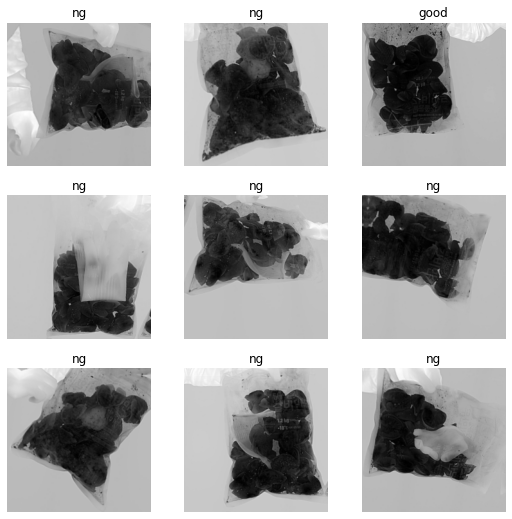

In [ ]:
dls.show_batch()

In [ ]:
print(dls.train_ds[0][0].shape)

(786, 982)


In [ ]:

# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5)
# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='best_model')

learn = cnn_learner(dls, resnet34, metrics=[accuracy, F1Score(), Recall()], cbs=[early_stop, save_model])

learn.fine_tune(10)

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pt

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.989153,1.462500,0.463636,0.495726,0.329545,01:01


Better model found at epoch 0 with valid_loss value: 1.4625004529953003.


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.472996,0.841750,0.654545,0.728571,0.579545,00:06
1,0.379981,0.435363,0.845455,0.893082,0.806818,00:06
2,0.282540,0.149372,0.918182,0.946746,0.909091,00:07
3,0.215843,0.111735,0.972727,0.982857,0.977273,00:06
4,0.175977,0.072497,0.990909,0.994350,1.000000,00:06
5,0.131640,0.060675,0.990909,0.994350,1.000000,00:06
6,0.104897,0.032838,0.990909,0.994350,1.000000,00:06
7,0.080645,0.025717,0.990909,0.994350,1.000000,00:06
8,0.063056,0.035131,0.990909,0.994350,1.000000,00:06
9,0.059428,0.024899,0.990909,0.994350,1.000000,00:06


Better model found at epoch 0 with valid_loss value: 0.8417499661445618.
Better model found at epoch 1 with valid_loss value: 0.4353625774383545.
Better model found at epoch 2 with valid_loss value: 0.14937233924865723.
Better model found at epoch 3 with valid_loss value: 0.11173513531684875.
Better model found at epoch 4 with valid_loss value: 0.07249663025140762.
Better model found at epoch 5 with valid_loss value: 0.0606747530400753.
Better model found at epoch 6 with valid_loss value: 0.03283831849694252.
Better model found at epoch 7 with valid_loss value: 0.025717390701174736.
Better model found at epoch 9 with valid_loss value: 0.02489948458969593.


In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

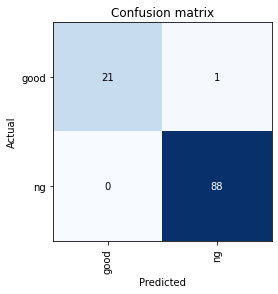

In [ ]:
interp.plot_confusion_matrix()

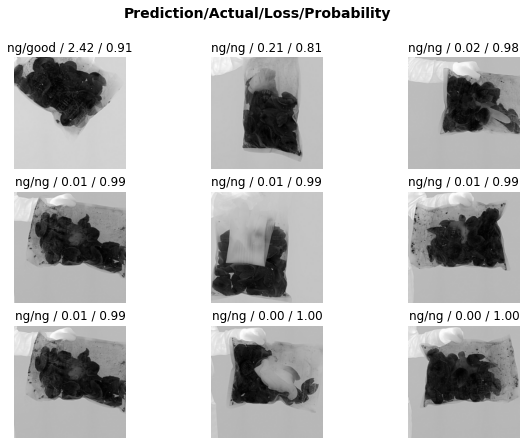

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

Better model found at epoch 0 with valid_loss value: 0.9909090995788574.
accuracy: 0.9909090995788574
Recall: 1.0
F1 score: 0.9943502824858756


# mobilenet

In [ ]:
import fastai
from fastai.vision.all import *
from PIL import Image
import cv2
from fastai.metrics import accuracy, F1Score, Recall
from fastai.interpret import ClassificationInterpretation

# For aesthetics
import warnings
warnings.filterwarnings('ignore')

fastai.__version__

'2.7.11'

In [ ]:
# datagen

path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')


# 기본 데이터 생성
# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
# get_items=get_image_files,
# get_y=parent_label,
# splitter=RandomSplitter(valid_pct=0.2, seed=42),
# item_tfms=[Resize(256)],
# batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

# dls = dblock.dataloaders(path, bs=32)


# 이미지변경
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(256), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=15.0,
                                               min_zoom=0.8,
                                               max_zoom=1.2,
                                               max_lighting=0.4,
                                               max_warp=0.4,
                                               p_affine=0.75,
                                               p_lighting=0.75),
                               Rotate(draw=15.0, p=0.5),
                               Dihedral(p=0.5),
                               RandomResizedCrop(256, min_scale=0.8),
                               Resize(224),
                               Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=32)

In [ ]:
# mobilenet
from torchvision.models import mobilenet_v2

class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        self.model = mobilenet_v2(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.model.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = MobileNetV2(num_classes=2)

In [ ]:
# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5)
# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='best_model')


learn = Learner(dls, model, metrics=[accuracy, F1Score(), Recall()], cbs=[early_stop,save_model])
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.297192,0.942940,0.845455,0.911917,1.000000,00:05


Better model found at epoch 0 with valid_loss value: 0.9429395794868469.


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.370186,0.543663,0.818182,0.871795,0.772727,00:06
1,0.285355,0.062846,0.981818,0.988506,0.977273,00:05
2,0.247975,0.031269,0.990909,0.994350,1.000000,00:06
3,0.281423,0.412717,0.845455,0.893082,0.806818,00:05
4,0.281464,0.021423,1.000000,1.000000,1.000000,00:06
5,0.252614,0.053564,0.981818,0.988506,0.977273,00:05
6,0.237226,0.501843,0.781818,0.842105,0.727273,00:06
7,0.224991,0.101256,0.954545,0.970760,0.943182,00:05
8,0.201746,0.019756,1.000000,1.000000,1.000000,00:05
9,0.183271,0.016871,1.000000,1.000000,1.000000,00:06


Better model found at epoch 0 with valid_loss value: 0.5436632037162781.
Better model found at epoch 1 with valid_loss value: 0.06284578889608383.
Better model found at epoch 2 with valid_loss value: 0.03126872330904007.
Better model found at epoch 4 with valid_loss value: 0.02142271213233471.
Better model found at epoch 8 with valid_loss value: 0.019755559042096138.
Better model found at epoch 9 with valid_loss value: 0.016870707273483276.


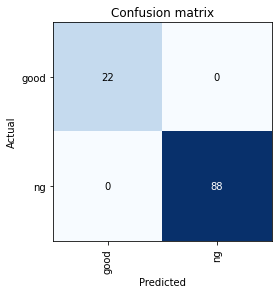

In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

interp.plot_confusion_matrix()

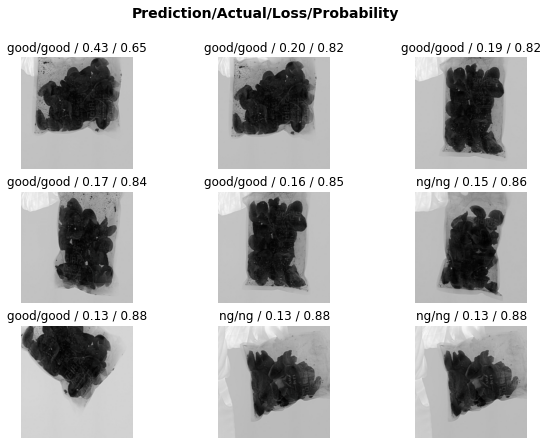

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(10,7))

In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

Better model found at epoch 0 with valid_loss value: 1.0.
accuracy: 1.0
Recall: 1.0
F1 score: 1.0


In [ ]:
learn.export('mobilenet_01.pkl')

In [ ]:
img = PILImage.create('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/augmentation/ng_label_0_3969.jpg')
img = img.resize((224,224), resample=Image.NEAREST)


In [ ]:
pred, pred_idx, probs = learn.predict(img)

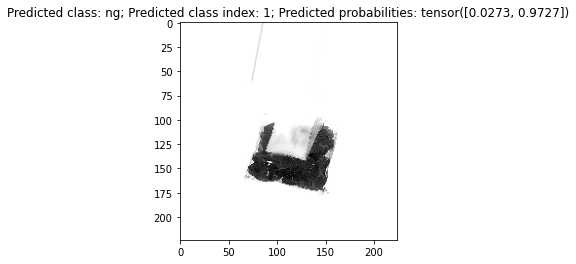

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img.to_thumb(224,224))
plt.title(f'Predicted class: {pred}; Predicted class index: {pred_idx}; Predicted probabilities: {probs}')
plt.show()

In [ ]:
# efficientnet-b0'

# Import necessary libraries
from fastai.vision.all import *
from fastai.vision.learner import cnn_learner
from torchvision.models import EfficientNet


# Set path to image folder
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

# Define data block
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[Resize(256)],
                   batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])

# Create dataloaders
dls = dblock.dataloaders(path, bs=64)


learn = cnn_learner(dls, efficientnet_b0, metrics=accuracy)

# Fine-tune the model on the dataset
learn.fit_one_cycle(10, lr_max=1e-3)



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.285553,0.841126,0.554545,00:15
1,1.057968,0.736408,0.718182,00:06
2,0.856443,0.336118,0.863636,00:07
3,0.738905,0.332642,0.881818,00:06
4,0.648453,0.510845,0.836364,00:07
5,0.596556,0.522374,0.863636,00:06
6,0.537505,0.439914,0.863636,00:06
7,0.491600,0.447731,0.854545,00:07
8,0.439760,0.346128,0.890909,00:06
9,0.408047,0.244245,0.918182,00:07


In [ ]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.255587,0.105841,0.963636,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.203987,0.074494,0.981818,00:06
1,0.184975,0.065450,0.972727,00:07
2,0.222863,0.052550,0.990909,00:06
3,0.204094,0.069640,0.981818,00:07
4,0.203751,0.064698,0.981818,00:06
5,0.188141,0.056933,0.990909,00:07
6,0.180200,0.059349,0.990909,00:07
7,0.164651,0.053738,0.990909,00:07
8,0.156894,0.054636,0.990909,00:07
9,0.143024,0.053173,0.990909,00:06


# 이미지 왜곡, 증폭 학습

In [ ]:
# 이미지 왜곡
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
# get_items=get_image_files,
# get_y=parent_label,
# splitter=RandomSplitter(valid_pct=0.2, seed=42),
# item_tfms=[RandomResizedCrop(256), Resize(224)],

# batch_tfms=[*aug_transforms(size=224,
#                             max_rotate=10.0,
#                             min_zoom=1.0,
#                             max_zoom=1.1,
#                             max_lighting=0.2,
#                             max_warp=0.2,
#                             p_affine=0.75,
#                             p_lighting=0.75),
#                             Rotate(draw=10.0, p=0.5),
#                             Normalize.from_stats(*imagenet_stats),
#                             ])

# dls = dblock.dataloaders(path, bs=32)

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(256), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=15.0,
                                               min_zoom=0.8,
                                               max_zoom=1.2,
                                               max_lighting=0.4,
                                               max_warp=0.4,
                                               p_affine=0.75,
                                               p_lighting=0.75),
                               Rotate(draw=15.0, p=0.5),
                               Dihedral(p=0.5),
                               RandomResizedCrop(256, min_scale=0.8),
                               Resize(224),
                               Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path, bs=32)




In [ ]:
# chat-gpt 이미지 전처리
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[RandomResizedCrop(256)],
    batch_tfms=[
        *aug_transforms(size=224,
                        max_rotate=15.0,
                        min_zoom=0.8,
                        max_zoom=1.2,
                        max_lighting=0.4,
                        max_warp=0.4,
                        p_affine=0.75,
                        p_lighting=0.75),
        Normalize.from_stats(*imagenet_stats)]
)

dls = dblock.dataloaders(path, bs=32)

# 데이터 전처리 함수 적용 전 이미지 개수
n_before = len(list(get_image_files(path)))
print(f"Original images: {n_before}")

# 데이터 전처리 함수 적용 후 이미지 개수
n_after = len(dls.train.items) + len(dls.valid.items)
print(f"Augmented images: {n_after - n_before}")

# 학습에 사용된 총 이미지 개수 확인
print(f"Total images: {n_after}")


Original images: 550
Augmented images: 0
Total images: 550


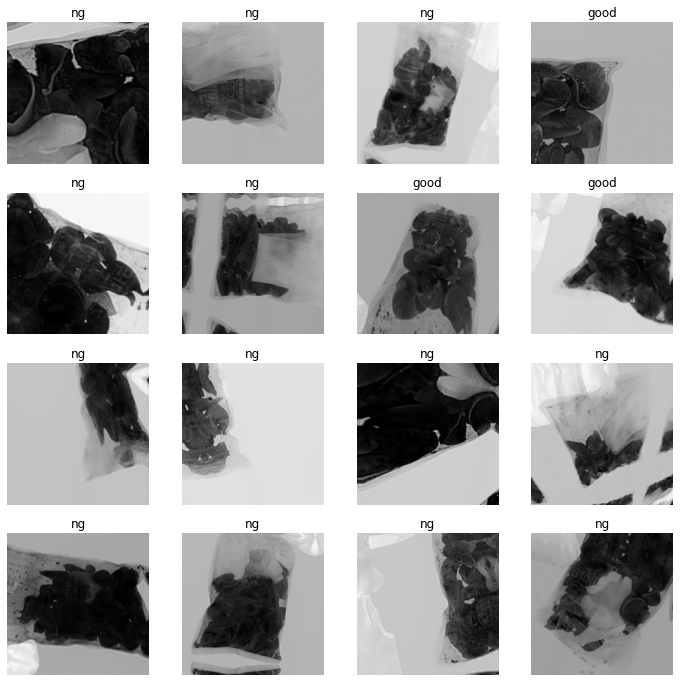

In [ ]:
#이미지 왜곡한 내용 확인
dls.show_batch(max_n=16)

In [ ]:
#학습
learn = cnn_learner(dls, resnet34, metrics=[accuracy, F1Score(), Recall()])

learn.fine_tune(2)

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,1.064706,3.210978,0.254545,0.127660,0.068182,00:05


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.879216,1.265611,0.563636,0.625000,0.454545,00:05
1,0.820532,0.358393,0.872727,0.914634,0.852273,00:05


In [ ]:
# 데이터 전처리 함수 적용 전 이미지 개수
n_before = len(list(get_image_files(path)))
print(f"Original images: {n_before}")

# 데이터 전처리 함수 적용 후 이미지 개수
n_after = len(dls.train_ds) + len(dls.valid_ds)
print(f"Augmented images: {n_after - n_before}")

# 학습에 사용된 총 이미지 개수 확인
print(f"Total images: {n_after}")

Original images: 550
Augmented images: 0
Total images: 550


In [ ]:
n_train = len(learn.dls.train_ds)
n_valid = len(learn.dls.valid_ds)
print(f"Number of images in training set: {n_train}")
print(f"Number of images in validation set: {n_valid}")


Number of images in training set: 440
Number of images in validation set: 110


In [ ]:
# define data block
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(256), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,                                                max_rotate=15.0,                                                min_zoom=0.8,                                                max_zoom=1.2,                                               max_lighting=0.4,                                                max_warp=0.4,                                                p_affine=0.75,                                                p_lighting=0.75),                               Rotate(draw=15.0, p=0.5),                               Dihedral(p=0.5),                               RandomResizedCrop(256, min_scale=0.8),                               Resize(224),                               Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path, bs=32)

# count number of images
n_original = len(get_image_files(path))
n_augmented = len(dls.train.items) - n_original
n_total = len(dls.train.items) + len(dls.valid.items)

# print results
print(f"Number of original images: {n_original}")
print(f"Number of augmented images: {n_augmented}")
print(f"Total number of images: {n_total}")


Number of original images: 550
Number of augmented images: -110
Total number of images: 550


In [ ]:
path = Path('/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img')

# Define data block and dataloaders
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[RandomResizedCrop(256), Resize(224)],
                   batch_tfms=[*aug_transforms(size=224,
                                               max_rotate=15.0,
                                               min_zoom=0.8,
                                               max_zoom=1.2,
                                               max_lighting=0.4,
                                               max_warp=0.4,
                                               p_affine=0.75,
                                               p_lighting=0.75),
                                                Rotate(draw=15.0, p=0.5),
                                                Dihedral(p=0.5),
                                                RandomResizedCrop(256, min_scale=0.8),
                                                Resize(224),
                                                Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path, bs=32)

# Count number of original images
n_original = len(get_image_files(path))

# Count number of augmented images
n_augmented = len(dls.train.items) - n_original

# Count total number of images
n_total = n_original + n_augmented

# Print results
print(f"Number of original images: {n_original}")
print(f"Number of augmented images: {n_augmented}")
print(f"Total number of images: {n_total}")


Number of original images: 550
Number of augmented images: -110
Total number of images: 440


In [ ]:
from fastai.interpret import ClassificationInterpretation


# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

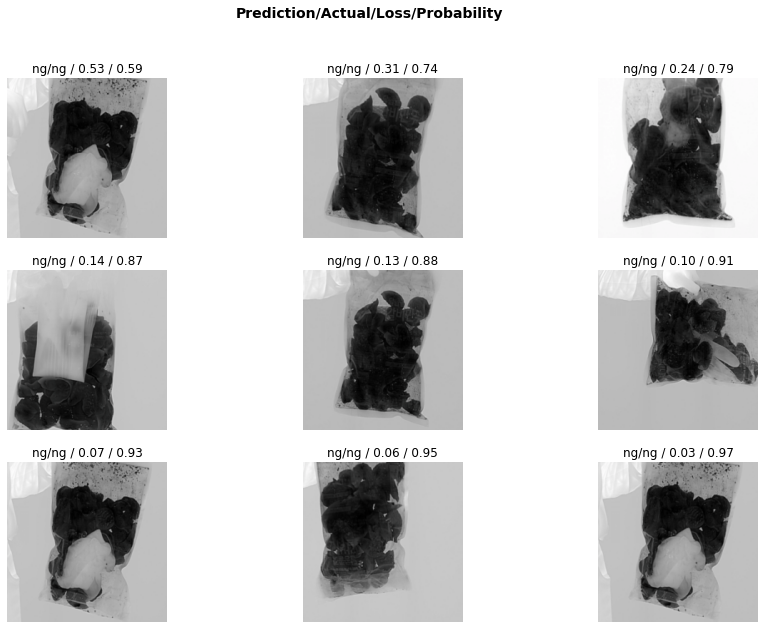

In [ ]:

# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(15,10))


In [ ]:
interp.plot_confusion_matrix()

In [ ]:
losses, idxs = interp.top_losses()

print('오답 결과:')
for i in range(len(idxs)):
    print(f'인덱스: {idxs[i]}, 손실 함수 값: {losses[i]}')

오답 결과:
인덱스: 79, 손실 함수 값: 0.5347505807876587
인덱스: 13, 손실 함수 값: 0.3073614537715912
인덱스: 31, 손실 함수 값: 0.23932725191116333
인덱스: 104, 손실 함수 값: 0.13831865787506104
인덱스: 7, 손실 함수 값: 0.1291535496711731
인덱스: 19, 손실 함수 값: 0.09812629222869873
인덱스: 89, 손실 함수 값: 0.0716668963432312
인덱스: 106, 손실 함수 값: 0.056269314140081406
인덱스: 25, 손실 함수 값: 0.03382764384150505
인덱스: 36, 손실 함수 값: 0.03087545931339264
인덱스: 22, 손실 함수 값: 0.029633190482854843
인덱스: 101, 손실 함수 값: 0.02848728373646736
인덱스: 96, 손실 함수 값: 0.027644965797662735
인덱스: 99, 손실 함수 값: 0.026298705488443375
인덱스: 33, 손실 함수 값: 0.02544466219842434
인덱스: 88, 손실 함수 값: 0.021640131250023842
인덱스: 73, 손실 함수 값: 0.020822962746024132
인덱스: 43, 손실 함수 값: 0.02037079446017742
인덱스: 66, 손실 함수 값: 0.018899131566286087
인덱스: 76, 손실 함수 값: 0.018735116347670555
인덱스: 12, 손실 함수 값: 0.010601865127682686
인덱스: 93, 손실 함수 값: 0.010166291147470474
인덱스: 44, 손실 함수 값: 0.009305793792009354
인덱스: 14, 손실 함수 값: 0.009187091141939163
인덱스: 50, 손실 함수 값: 0.00867893174290657
인덱스: 94, 손실 함수 값: 0.0085200862959

In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

# 수평 이미지 fastai

In [1]:
import fastai
from fastai.vision.all import *
from PIL import Image
from fastai.metrics import accuracy, F1Score, Recall

In [7]:
path = '/content/drive/MyDrive/Colab Notebooks/10.cj_project/datasets/img_cls/fm_img_hori'

In [8]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
get_y=parent_label,
splitter=RandomSplitter(valid_pct=0.2, seed=42),
item_tfms=[RandomResizedCrop(256), Resize(224)],
batch_tfms=[*aug_transforms(size=224, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1,
                                              max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),
                               Rotate(draw=10.0, p=0.5),
                               Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=16)

learn = cnn_learner(dls, resnet34, metrics=[accuracy, F1Score(), Recall()])

learn.fine_tune(10)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,1.249198,0.498257,0.833333,0.908555,0.968553,00:52


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,time
0,0.779035,0.633533,0.693548,0.789668,0.672956,00:17
1,0.664226,0.450335,0.817204,0.891026,0.874214,00:19
2,0.587725,0.360834,0.833333,0.905775,0.937107,00:18
3,0.511360,0.229930,0.903226,0.945783,0.987421,00:16
4,0.428449,0.152213,0.924731,0.956522,0.968553,00:16
5,0.386220,0.212782,0.913979,0.947712,0.911950,00:16
6,0.353736,0.137756,0.946237,0.969512,1.000000,00:17
7,0.342646,0.112139,0.956989,0.974843,0.974843,00:18
8,0.319064,0.107927,0.962366,0.978328,0.993711,00:17
9,0.297622,0.112198,0.946237,0.969512,1.000000,00:19


In [ ]:
from fastai.interpret import ClassificationInterpretation


# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()


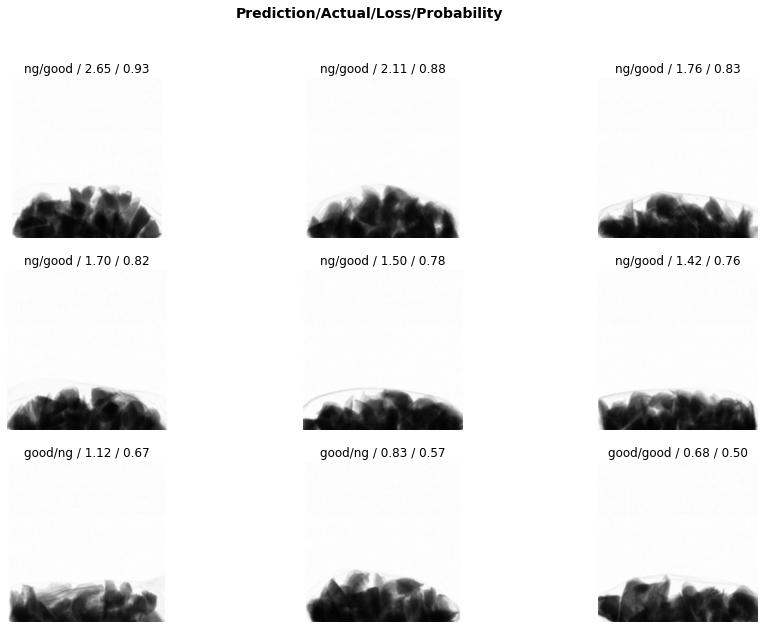

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(15,10))

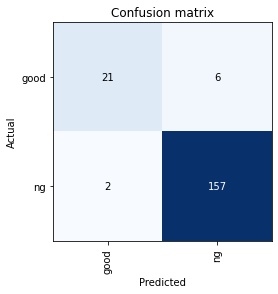

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

accuracy: 0.9569892287254333
Recall: 0.9874213836477987
F1 score: 0.9751552795031055


In [5]:
import fastai
from fastai.vision.all import *
from PIL import Image
import cv2
from fastai.callback import *
from fastai.callback.all import *
from fastai.interpret import ClassificationInterpretation


path = Path('/content/drive/MyDrive/Colab Notebooks/datasets/fm_img_hori')

In [6]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(460, method='pad', pad_mode='zeros'),
                   batch_tfms=[
                       *aug_transforms(size=224, min_scale=0.5, flip_vert=True, max_zoom=1.2, max_rotate=20, max_lighting=0.4),
                       # Rotate(max_deg=45, p=0.8), # 주석 처리
                       # Canny(), # 주석 처리
                       Normalize.from_stats(*imagenet_stats)
                   ])
dls = dblock.dataloaders(path, bs=16)

# EarlyStoppingCallback 정의
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5)

# SaveModelCallback 정의
save_model = SaveModelCallback(monitor='valid_loss', fname='best_model')


learn = cnn_learner(dls, resnet34, metrics=[accuracy, F1Score(), Recall()],
                    cbs=[early_stop, save_model])




learn.fit_one_cycle(10, 1e-3)

TypeError: ignored

In [ ]:
# 예측값과 실제값 추출
interp = ClassificationInterpretation.from_learner(learn)
preds, targs = interp.top_losses()

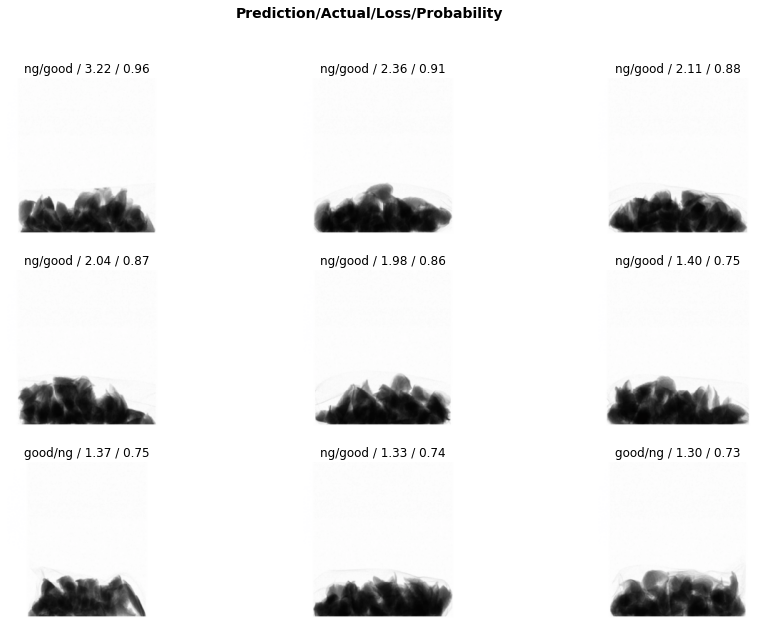

In [ ]:
# 오답 결과 시각화
interp.plot_top_losses(9, figsize=(15,10))

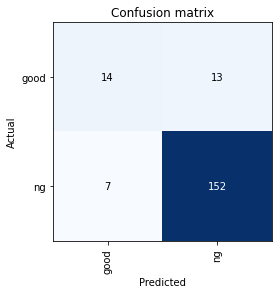

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
# 모델의 accuracy, f1 score, recall 출력
accuracy_value = learn.validate()[1]
f1_score_value = learn.metrics[1].value
recall_value = learn.metrics[2].value

print('accuracy:', accuracy_value)
print('Recall:', recall_value)
print('F1 score:', f1_score_value)

Better model found at epoch 0 with valid_loss value: 0.8924731016159058.
accuracy: 0.8924731016159058
Recall: 0.9559748427672956
F1 score: 0.9382716049382717
